In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
plt.style.use("seaborn-v0_8")
import os
import soundfile as sf

2025-05-31 14:58:27.523460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
fn_csv = 'scenes_stereo/dcase2013_task1_filenamekey.csv'
df = pd.read_csv(fn_csv)
files = []
labels = []
files = df['decodedname']
labels = df['label']
print(len(files))
print(len(labels))
audio_path = 'scenes_stereo/scenes_stereo/'

200
200


In [4]:
from sklearn.preprocessing import LabelEncoder
unique_labels = labels.unique()
print(unique_labels)
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(unique_labels)
print(encoded_labels)
sorted_labels = [label for _, label in sorted(zip(encoded_labels, unique_labels))]
print(sorted_labels)

['office' 'tube' 'restaurant' 'busystreet' 'bus' 'supermarket'
 'openairmarket' 'park' 'quietstreet' 'tubestation']
[2 8 6 1 0 7 3 4 5 9]
['bus', 'busystreet', 'office', 'openairmarket', 'park', 'quietstreet', 'restaurant', 'supermarket', 'tube', 'tubestation']


In [5]:
files_train, files_test, labels_train, labels_test = train_test_split(files, labels, test_size=50, random_state=42, shuffle=True)
# specificando il random_state ad ogni run ci sarà sempre lo stesso split (riproducibilità)

print(len(files_train))  # 150
print(len(files_test))   # 50
print(len(labels_train))  # 150
print(len(labels_test))   # 50

150
50
150
50


In [18]:
import librosa

augmented_data = []
fast_files = []
slow_files = []

for i, file in enumerate(files_train):
    signal, sr = librosa.load(audio_path + file)
    label = labels_train.iloc[i]
    base_name = os.path.splitext(file)[0]  # es: 'bus12.wav' → 'bus12'

    # Aggiungi il segnale originale
    augmented_data.append((signal, label, f"{base_name}_orig.wav"))

    # Crea versioni augmentate
    versions = {
        'stretch_fast': librosa.effects.time_stretch(signal, rate=1.2), # da levare, peggiorano l'accuracy
        'stretch_slow': librosa.effects.time_stretch(signal, rate=0.8), # idem
        'pitch_up': librosa.effects.pitch_shift(signal, sr=sr, n_steps=2),
        'pitch_down': librosa.effects.pitch_shift(signal, sr=sr, n_steps=-2)
    }

    # Aggiungi i segnali augmentati alla lista
    for suffix, aug_signal in versions.items():
        filename = f"{base_name}_{suffix}.wav"
        augmented_data.append((aug_signal, label, filename))
        if "stretch_fast" in suffix:
            fast_files.append(filename)
        elif "stretch_slow" in suffix:
            slow_files.append(filename)

In [12]:
print(len(fast_files))
print(len(slow_files))

0
0


In [13]:
fs = 22050 # solo per assicurarsi che altre funzioni non la cambino

In [14]:
import os
import soundfile as sf
import shutil

augmented_path = 'scenes_stereo_augmented/'

# Cancella e ricrea la cartella
if os.path.exists(augmented_path):
    shutil.rmtree(augmented_path)
os.makedirs(augmented_path)

test_path = 'scenes_stereo_test/'
os.makedirs(augmented_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)


files_train_aug = []
labels_train_aug = []

for i, (signal, label, filename) in enumerate(augmented_data):
    filepath = os.path.join(augmented_path, filename)
    if filename in fast_files:
        signal_resampled = librosa.resample(signal, orig_sr=fs, target_sr=int(fs*1.2))
        augmented_data[i] = (signal_resampled, label, filename)
        sf.write(filepath, signal_resampled, int(fs*1.2))
    elif filename in slow_files:
        signal_resampled = librosa.resample(signal, orig_sr=fs, target_sr=int(fs*0.8))
        augmented_data[i] = (signal_resampled, label, filename)
        sf.write(filepath, signal_resampled, int(fs*0.8))
    else:
        sf.write(filepath, signal, fs)

    files_train_aug.append(filename)
    labels_train_aug.append(label)

# ho resamplato i file stretchati in modo che avessero lo stesso numero di campioni degli altri

In [17]:
print(len(files_train_aug))
print(len(files_test))
print(len(labels_train_aug))
print(len(labels_test))

450
50
450
50


In [15]:
signals_fs = [librosa.load(audio_path + file) for file in files_test]
X_test = [s[0] for s in signals_fs]
print(len(X_test))
y_test = labels_test
print(len(y_test))

# test è ok, con X_test (segnali) e y_test (label)

50
50


In [16]:
X_train = [s for s, l, f in augmented_data]
y_train = [l for s, l, f in augmented_data]

In [17]:
print(len(X_train))
print(len(y_train))

# train è ok, con X_train (segnali) e y_train (label)

750
750


In [13]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# (750, 661500)
# (750, )
# (50, 661500)
# (50, )

(450, 661500)
(450,)
(50, 661500)
(50,)


In [15]:
'''
fs = 22050 # non fa mai male ridichiararla
time_axis = np.arange(len(signals[0]))/fs
'''

NameError: name 'signals' is not defined

In [ ]:
'''

for i in range(50):
    plt.figure(figsize = (10, 5))
    plt.xlabel('time (s)')
    plt.plot(time_axis, X_test[i])
    plt.show()
    print(y_test[i])

'''

In [16]:
w = 512
h = 256
n = 2048

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
def feature_extraction(x, fs, n, h):
    zcr = librosa.feature.zero_crossing_rate(x, hop_length = h)
    mean_zcr = np.mean(zcr)
    std_zcr = np.std(zcr)
    stft = np.abs(librosa.stft(x, n_fft=n, hop_length=h))**2
    melspec = (librosa.feature.melspectrogram(S=stft, n_mels=128))
    pcen_spec = librosa.pcen(melspec, sr=fs)
    melspec = librosa.power_to_db(melspec)
    mean_pcen = np.mean(pcen_spec)
    std_pcen = np.std(pcen_spec)
    delta_melspec = librosa.feature.delta(melspec)
    delta2_melspec = librosa.feature.delta(delta_melspec)
    mean_mel = np.mean(melspec)
    std_mel = np.std(melspec)
    mean_deltamel = np.mean(delta_melspec)
    std_deltamel = np.std(delta_melspec)
    mean_delta2mel = np.mean(delta2_melspec)
    std_delta2mel = np.std(delta2_melspec)
    C = np.abs(librosa.stft(x, n_fft = n, hop_length = h))
    S = librosa.amplitude_to_db(C, ref = np.max)
    spectral_flux = librosa.onset.onset_strength(S = S, sr = fs)
    mean_spectral_flux = np.mean(spectral_flux)
    std_spectral_flux = np.std(spectral_flux)
    spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=fs)
    mean_spectral_contrast = np.mean(spectral_contrast)
    std_spectral_contrast = np.std(spectral_contrast)
    tonnetz = librosa.feature.tonnetz(y=x, sr=fs)
    mean_tonnetz = np.mean(tonnetz)
    std_tonnetz = np.std(tonnetz)
    
    f_vector = np.concatenate(([mean_spectral_contrast, std_spectral_contrast], [mean_tonnetz, std_tonnetz], [mean_zcr, std_zcr], [mean_mel, std_mel], [mean_deltamel, std_deltamel], [mean_delta2mel, std_delta2mel], [mean_spectral_flux, std_spectral_flux], [mean_pcen, std_pcen]))
    return f_vector

In [70]:
f_vector_train = np.zeros((X_train.shape[0], 16))
f_vector_test = np.zeros((X_test.shape[0], 16))
# se aggiungete/togliete feature dal f_vector ricordatevi di cambiare la dimensione

for i in range(0, X_train.shape[0]):
    f_vector_train[i, :] = feature_extraction(X_train[i, :], fs = fs, n = n, h = h)
for i in range(0, X_test.shape[0]):
    f_vector_test[i, :] = feature_extraction(X_test[i, :], fs = fs, n = n, h = h)

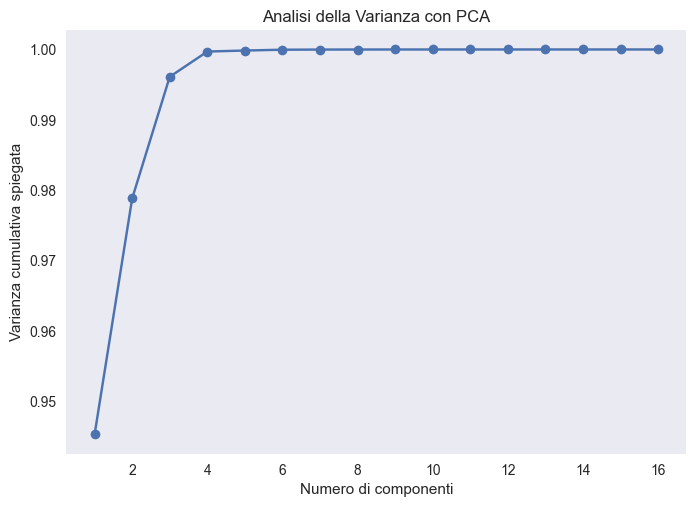

In [63]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(f_vector_train)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o")
plt.xlabel("Numero di componenti")
plt.ylabel("Varianza cumulativa spiegata")
plt.title("Analisi della Varianza con PCA")
plt.grid()
plt.show()

In [ ]:
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(f_vector_train)

# Creiamo un dataframe per interpretare i pesi delle feature
feature_names = ["mean_zcr", "std_zcr", "mean_mel", "std_mel", "mean_deltamel", "std_deltamel",
                 "mean_delta2mel", "std_delta2mel", "mean_spectral_flux", "std_spectral_flux", "mean_mfcc", "std_mfcc"]

loadings = pd.DataFrame(pca.components_.T, index=feature_names, columns=[f"PC{i+1}" for i in range(n_components)])
print(loadings)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(loadings)
plt.title("Contributo delle feature nelle componenti PCA")
plt.show()

In [ ]:
'''

print(f_vector_train.shape)
print(f_vector_train[0, :])
print(f_vector_train[100, :])
plt.plot(f_vector_train[0, :])

'''

In [72]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

mod = SVC(kernel = 'linear', C = 100)
mod.fit(f_vector_train, y_train)
train_pred = mod.predict(f_vector_train)
accuracy = accuracy_score(y_train, train_pred)
print('train: ', accuracy)
test_pred = mod.predict(f_vector_test)
accuracy = accuracy_score(y_test, test_pred)
print('test: ', accuracy)

# overfitta!! togliendo mfcc dal feature_vector migliora, però forse il problema è che abbiamo troppi dati di train perché prima con solo 150 andava meglio

train:  0.7822222222222223
test:  0.74


In [ ]:
# aug: 450 (solo pitch), 10 feature (no mfcc), C = 10000

# acc train: 0.8
# acc test: 0.72

# con n = 2048 e h = 256, C = 100
# acc train: 0.7
# acc test: 0.74

               precision    recall  f1-score   support

          bus       0.97      0.95      0.96        39
   busystreet       0.88      0.98      0.93        45
       office       0.62      0.86      0.72        42
openairmarket       0.83      0.95      0.89        42
         park       0.55      0.44      0.49        48
  quietstreet       0.72      0.69      0.70        45
   restaurant       0.86      0.82      0.84        45
  supermarket       0.80      0.81      0.81        54
         tube       0.78      0.88      0.82        48
  tubestation       0.87      0.48      0.62        42

     accuracy                           0.78       450
    macro avg       0.79      0.79      0.78       450
 weighted avg       0.79      0.78      0.77       450



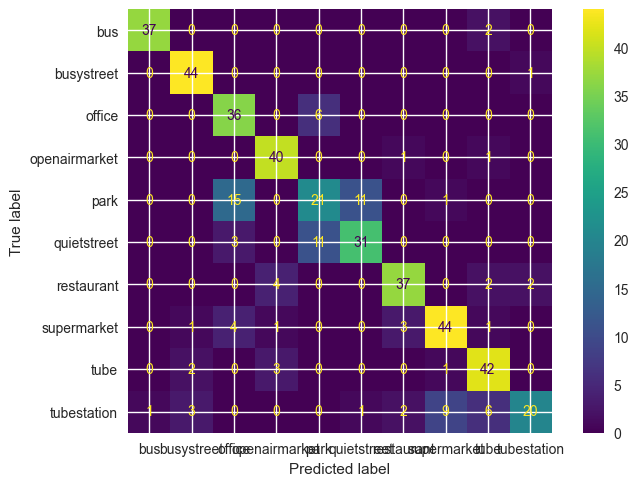

In [73]:
cm_train = confusion_matrix(y_train, train_pred)
(ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = sorted_labels)).plot()

rep = classification_report(y_train, train_pred)
print(rep)

''' 
male:
recall di tubestation (falsi neg)
tutto di park
'''

               precision    recall  f1-score   support

          bus       1.00      0.86      0.92         7
   busystreet       0.56      1.00      0.71         5
       office       0.86      1.00      0.92         6
openairmarket       0.83      0.83      0.83         6
         park       1.00      0.50      0.67         4
  quietstreet       0.80      0.80      0.80         5
   restaurant       0.57      0.80      0.67         5
  supermarket       0.33      0.50      0.40         2
         tube       0.80      1.00      0.89         4
  tubestation       0.00      0.00      0.00         6

     accuracy                           0.74        50
    macro avg       0.68      0.73      0.68        50
 weighted avg       0.69      0.74      0.70        50



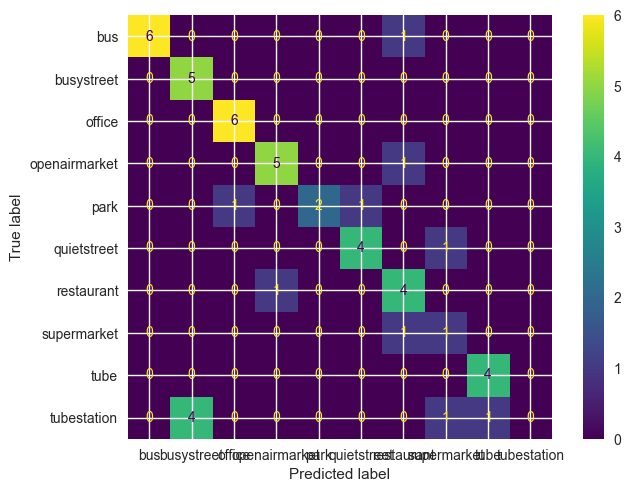

In [76]:
cm_test = confusion_matrix(y_test, test_pred)
(ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = sorted_labels)).plot()

rep = classification_report(y_test, test_pred, zero_division = 0)
print(rep)

In [41]:
from sklearn.neighbors import KNeighborsClassifier

k = 10
knn = KNeighborsClassifier(n_neighbors=k)

# Allenare il modello
knn.fit(f_vector_train, y_train)

train_pred = knn.predict(f_vector_train)
accuracy = accuracy_score(y_train, train_pred)
print('train: ', accuracy)
test_pred = knn.predict(f_vector_test)
accuracy = accuracy_score(y_test, test_pred)
print('test: ', accuracy)

# decisamente no

train:  0.44
test:  0.4


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_2d_cnn(input_shape=(128, 128, 1), num_classes=10):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    # Dense
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [ ]:
model = build_2d_cnn(input_shape=(128, 128, 1), num_classes=10)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # o categorical_crossentropy se hai one-hot
    metrics=['accuracy']
)

model.summary()
